In [ ]:
from paths import paths
import torch
import os
import pickle
import matplotlib.pyplot as plt
from tokenizers import Tokenizer
import sys
from transformer_components_michaelkosmider import TransformerEncoderDecoder
from image_captioner import ImageEncoder, CaptionDecoder, ImageAutoEncoder, ImageDecoder
import yaml
from coco_loader import get_coco_loader, decode_predictions
from image_transforms import (
    encoder_image_transform_index,
    captioner_image_transform_index,
    mean,
    std,
    to_rgb,
)
from PIL import Image
import matplotlib.pyplot as plt
import evaluate
from tqdm import tqdm
from train_encoder import get_patch_indices
import torch.nn as nn
from pprint import pprint

In [136]:
# To be replaced with checkpoint configs.
with open(paths["captioner_config"], "r") as f:
    captioner_config = yaml.safe_load(f)
with open(paths["encoder_config"], "r") as f:
    encoder_config = yaml.safe_load(f)

# Set device.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
print(f"You are using {device}.")

You are using mps.


## Load in Encoder and Captioner Checkpoints


In [137]:
encoder_checkpoint_path = os.path.join(paths["encoder_checkpoint"], "checkpoint17.pt")

if os.path.exists(encoder_checkpoint_path):
    encoder_checkpoint = torch.load(encoder_checkpoint_path, pickle_module=pickle)
else:
    print(f"The path {encoder_checkpoint_path} does not exist!")
    sys.exit(1)

captioner_checkpoint_path = os.path.join(
    paths["captioner_checkpoint"], "checkpoint9.pt"
)

if os.path.exists(captioner_checkpoint_path):
    captioner_checkpoint = torch.load(
        captioner_checkpoint_path, pickle_module=pickle, map_location=device
    )
else:
    print(f"The path {captioner_checkpoint_path} does not exist!")
    sys.exit(1)

## View Training History


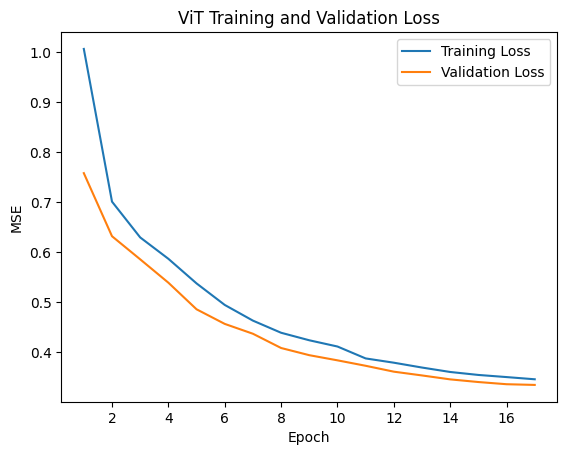

In [138]:
train_losses = encoder_checkpoint["history"]["train_losses"]
val_losses = encoder_checkpoint["history"]["val_losses"]
epochs = range(1, len(train_losses) + 1)

plt.plot(epochs, train_losses, label="Training Loss")
plt.plot(epochs, val_losses, label="Validation Loss")

plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("ViT Training and Validation Loss")
plt.legend()
plt.show()

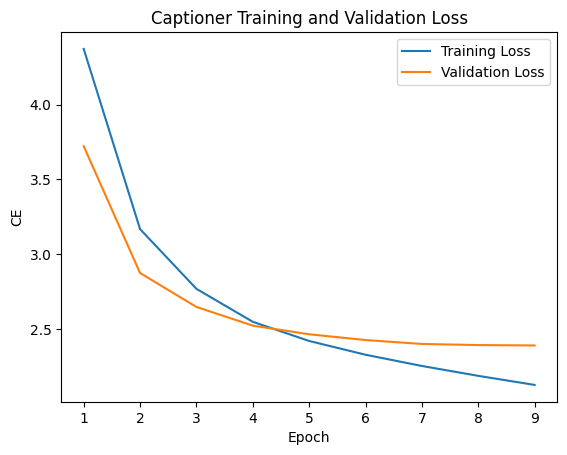

In [139]:
train_losses = captioner_checkpoint["history"]["train_losses"]
val_losses = captioner_checkpoint["history"]["val_losses"]
epochs = range(1, len(train_losses) + 1)

plt.plot(epochs, train_losses, label="Training Loss")
plt.plot(epochs, val_losses, label="Validation Loss")

plt.xlabel("Epoch")
plt.ylabel("CE")
plt.title("Captioner Training and Validation Loss")
plt.legend()
plt.show()

## Results


In [140]:
# Decode and Evaluate

if os.path.exists(paths["results"]):
    results = torch.load(paths["results"], weights_only=False)
    decoded_preds, decoded_refs, image_ids, bleu_score, percentage_used = (
        results.values()
    )
else:
    # Initialize model and tokenizer.

    tokenizer = Tokenizer.from_file(paths["tokenizer"])

    SOS_IDX = tokenizer.token_to_id("<SOS>")
    EOS_IDX = tokenizer.token_to_id("<EOS>")
    PAD_IDX = tokenizer.token_to_id("<PAD>")

    BATCH_SIZE = captioner_config["batch_size"]
    NUM_WORKERS = captioner_config["num_workers"]

    VOCAB_SIZE = captioner_config["vocab_size"]
    CONTEXT_SIZE = captioner_config["context_size"]
    PATCH_SIZE = captioner_config["patch_size"]
    IMAGE_SIZE = captioner_config["image_size"]
    LENGTH_ALPHA = float(captioner_config["length_alpha"])
    NUM_BEAMS = captioner_config["num_beams"]

    image_encoder_config = captioner_config["image_encoder"]
    caption_decoder_config = captioner_config["caption_decoder"]

    model = TransformerEncoderDecoder(
        ImageEncoder(IMAGE_SIZE, PATCH_SIZE, image_encoder_config),
        CaptionDecoder(VOCAB_SIZE, CONTEXT_SIZE, caption_decoder_config),
    ).to(device)

    model.load_state_dict(captioner_checkpoint["model_state_dict"])
    bleu = evaluate.load("bleu")
    epoch = captioner_checkpoint["history"]["epochs_completed"]

    # Get the loader for BLEU
    loader_for_metrics = get_coco_loader(
        "val",
        BATCH_SIZE,
        captioner_image_transform_index["val"],
        NUM_WORKERS,
        mode="image_first",
        pin_memory=True if device == "cuda" else False,
    )
    metric_batches = tqdm(
        loader_for_metrics,
        desc=f"Metrics for epoch {epoch}:",
        leave=True,
    )

    model.eval()
    with torch.no_grad():
        decoded_preds = []
        decoded_refs = []
        image_ids = []
        for img, references, ids in metric_batches:
            img = img.to(device)
            pred = model.generate(
                img,
                None,
                NUM_BEAMS,
                CONTEXT_SIZE,
                LENGTH_ALPHA,
                SOS_IDX,
                PAD_IDX,
                EOS_IDX,
            )
            decoded_preds.extend(decode_predictions(pred, tokenizer))
            decoded_refs.extend([tokenizer.decode_batch(ref) for ref in references])
            image_ids.extend(ids)

    # Remove any empty predictions. Record percentage.
    cleaned_preds = []
    cleaned_refs = []
    for pred, ref in zip(decoded_preds, decoded_refs):
        if pred.strip():
            cleaned_preds.append(pred)
            cleaned_refs.append(ref)

    if len(cleaned_preds) == 0:
        print("Unable to compute BLEU: no non-empty predictions.")
        bleu_score = None
        percentage_used = 0
    else:
        bleu_score = bleu.compute(predictions=cleaned_preds, references=cleaned_refs)
        percentage_used = 100 * len(cleaned_preds) / len(decoded_preds)

    results = {
        "decoded_preds": decoded_preds,
        "decoded_refs": decoded_refs,
        "image_ids": image_ids,
        "bleu": bleu_score,
        "percentage_used": percentage_used,
    }
    torch.save(results, paths["results"], pickle_module=pickle)

### Final BLEU-4


In [141]:
bleu_score["bleu"]

0.21440939203050188

### Selected Samples


In [142]:
def inspect(idx):

    # Replace with your image path
    image_path = os.path.join(paths["images"]["val"], f"{image_ids[idx]:012}.jpg")

    # Load image using PIL
    img = Image.open(image_path)

    plt.imshow(img)
    plt.axis("off")
    plt.show()
    print(f"Prediction: {decoded_preds[idx]}")
    print("Truth:")
    for sentence in decoded_refs[idx]:
        print(f"\t{sentence}")

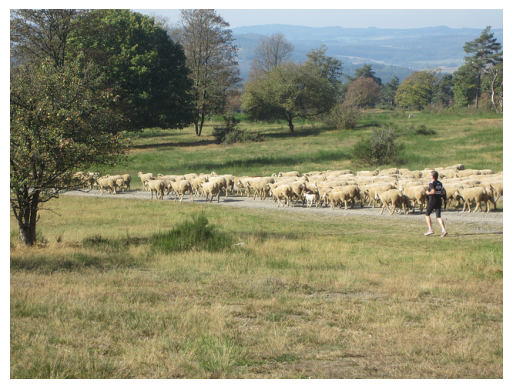

Prediction: a herd of sheep standing on top of a lush green field .
Truth:
	a herd of animals traveling down a country road surrounded by a lush green landscape .
	jo gg er running past a flock of sheep in a rural area
	a man walking beside sheep on a country road .
	jo gg er running past a flock of white sheep .
	a runner wearing sp and ex has come across a large herd traveling down the dirt road .


In [143]:
inspect(67)

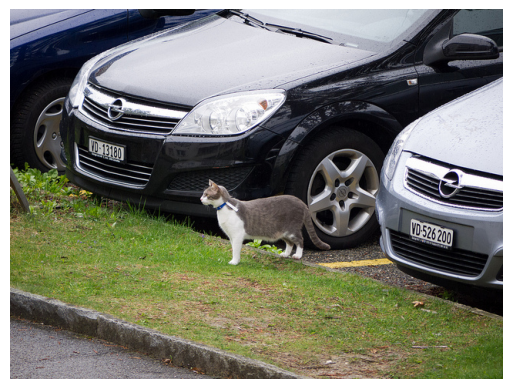

Prediction: a dog that is sitting in the grass next to a car .
Truth:
	a cat in between two cars in a parking lot .
	a cat stands between two parked cars on a grassy sidewalk .
	a cat at attention between two parked cars .
	a grey and white cat watches from between parked cars .
	a grey and white cat standing in the grass in a parking lot .


In [144]:
inspect(7)

### Inspecting ViT Pixel Predictions


In [145]:
# Initialize model.
with open(paths["encoder_config"]) as f:
    config = yaml.safe_load(f)

IMAGE_SIZE = config["image_size"]
PATCH_SIZE = config["patch_size"]
MASKING_RATIO = config["masking_ratio"]
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2
NUM_MASKED_PATCHES = int(NUM_PATCHES * MASKING_RATIO)
NUM_WORKERS = config["num_workers"]
BATCH_SIZE = config["batch_size"]

image_encoder_config = config["image_encoder"]
image_decoder_config = config["image_decoder"]

model = ImageAutoEncoder(
    ImageEncoder(IMAGE_SIZE, PATCH_SIZE, image_encoder_config),
    ImageDecoder(PATCH_SIZE, NUM_PATCHES, image_decoder_config),
).to(device)

model.image_encoder.load_state_dict(encoder_checkpoint["image_encoder_state_dict"])
model.image_decoder.load_state_dict(encoder_checkpoint["image_decoder_state_dict"])

<All keys matched successfully>

In [ ]:
# Predict a batch of images
image_only_loader = iter(
    get_coco_loader(
        "val",
        16,
        encoder_image_transform_index["val"],
        4,
        mode="image_only",
        pin_memory=True if device == "cuda" else False,
    )
)

image = next(image_only_loader).to(device)
masked_positions, unmasked_positions = get_patch_indices(
    image.shape[0], NUM_PATCHES, MASKING_RATIO, image.device
)
# Get ground truth masked patches
patch_extracter = nn.Unfold(kernel_size=PATCH_SIZE, stride=PATCH_SIZE)
ground_image_patches = patch_extracter(image).transpose(-1, -2)
ground_inds = masked_positions.unsqueeze(-1).expand(
    -1, -1, ground_image_patches.shape[-1]
)
ground_masked_patches = torch.gather(ground_image_patches, dim=1, index=ground_inds)

# Get predictions for masked patches
reconstructed_image_patches = model(image, unmasked_positions)
pred_masked_patches = torch.gather(
    reconstructed_image_patches, dim=1, index=ground_inds
)

# Reconstruct entire image
image_gluer = nn.Fold(
    output_size=(IMAGE_SIZE, IMAGE_SIZE), kernel_size=PATCH_SIZE, stride=PATCH_SIZE
)
reconstructed_image = image_gluer(reconstructed_image_patches.transpose(-1, -2))

### Inspecting a Random Image


In [147]:
idx = 8

'Image number 8:'


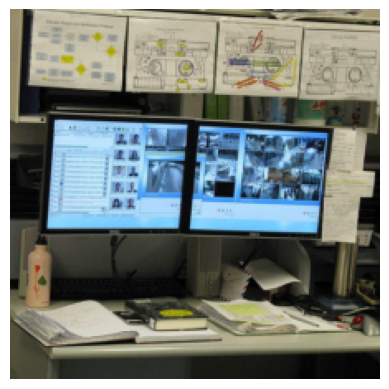

In [148]:
pprint(f"Image number {idx}:")
plt.imshow(to_rgb(image[idx], mean, std))
plt.axis("off")
plt.show()

'Image number 8 reconstruction:'


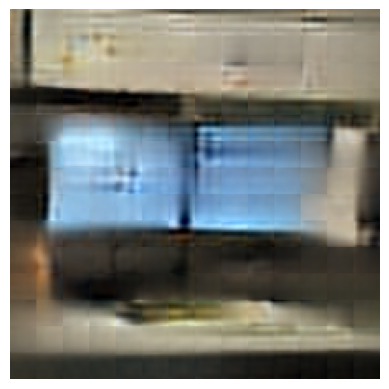

In [149]:
pprint(f"Image number {idx} reconstruction:")
plt.imshow(to_rgb(reconstructed_image[idx], mean, std))
plt.axis("off")
plt.show()

## Zooming in on a Masked Patch


In [150]:
random_patch_idx = 15
patch_position = masked_positions[idx][random_patch_idx]
one_ground_patch = ground_masked_patches[idx][random_patch_idx].view(
    3, PATCH_SIZE, PATCH_SIZE
)
one_pred_patch = pred_masked_patches[idx][random_patch_idx].view(
    3, PATCH_SIZE, PATCH_SIZE
)

'Image number 8, patch number 112'
'Truth:'


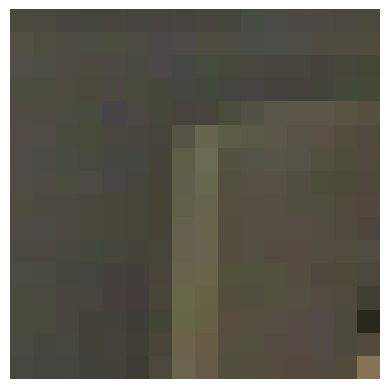

'Prediction:'


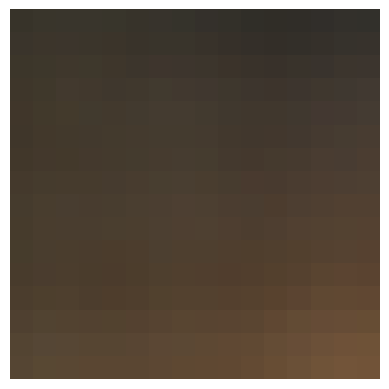

In [151]:
pprint(f"Image number {idx}, patch number {patch_position}")
pprint(f"Truth:")
plt.imshow(to_rgb(one_ground_patch, mean, std))
plt.axis("off")
plt.show()
pprint(f"Prediction:")
plt.imshow(to_rgb(one_pred_patch, mean, std))
plt.axis("off")
plt.show()